In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from glob import glob
import os
import yaml
from skimage.io import imread
import stretchablecorr as sc

# Stretchable Corr - Post-process

## Search and select images

In [69]:
def get_stretch(image_name, sample_name):
    """extract stretch value from filename

    ex: hpr10p100031.TIF --> 0.1%
    """
    image_name = image_name.replace(sample_name, '')
    image_name = image_name.split('.')[0]
    u, d = image_name.split('p')
    d = d[:1]
    s = float(u) + float(d)/10
    return s

Available samples
0 - example_PDMS_18j
1 - .ipynb_checkpoints
2 - not_used
3 - HS2
4 - hpr1


> Select an image directory: 3


HS2 selected
Load images from ./images/HS2...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF


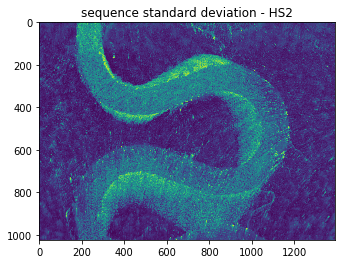

In [70]:
# ==================
#  Load image cube
# ==================
sample_name, sample_input_dir = sc.select_sample_dir('./images')
cube, image_names = sc.load_image_sequence(sample_input_dir)

output_dir = 'output'
resultdir = os.path.join(output_dir, sample_name)

# Graph std
plt.figure(); plt.title(f'sequence standard deviation - {sample_name}');
plt.imshow(np.std(cube, axis=0), cmap='viridis');
sc.save_fig('01_cube_std', sample_name, output_dir=output_dir)


In [71]:
# Extract stretch value from filenames
stretch_values = [get_stretch(n, '') for n in image_names]
print('\n', f'{len(stretch_values)} stretch values extracted')
print(stretch_values)


 23 stretch values extracted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.2, 1.4, 1.6, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 30.0, 35.0, 45.0, 50.0, 55.0]


## Lagrangian displacement

In [72]:
# ========================
#  List available dataset
# ========================
datasets = glob(os.path.join(resultdir, '*.pck'))

print(f'Available dataset for {sample_name}')
print( '======================' + '='*len(sample_name) )
sc.print_numbered_list([os.path.basename(d) for d in datasets])

# Select a sample:
dataset_id = input('> Select a file:')
data_file = datasets[int(dataset_id)]
print(data_file)

# Load dataset
with open(data_file, 'rb') as f:
    grid, displ, err, meta = pickle.load(f)

window_half_size = meta['window_half_size']
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

# Integrate displacement 
displ_to_ref = sc.integrate_displacement(displ)

print('')
print('Parameters:')
print('===========')
print(yaml.dump(meta, default_flow_style=False))

Available dataset for HS2
0 - displ_Lagrangian_4400pts_160905.pck
1 - displ_Lagrangian_2035pts_162211.pck


> Select a file: 0


output/HS2/displ_Lagrangian_4400pts_160905.pck

Parameters:
coarse_downscale: 3
coarse_param:
  method: opti
  phase: true
  window_half_size: 35
grid_margin: 100
grid_spacing: 15
method: opti
phase: false
sample_name: HS2
window_half_size: 20



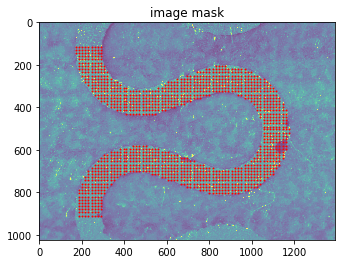

In [73]:
# =========================
#  Load an image as a MASK
# =========================
image_mask_path = f'images/{sample_name}_mask.png'
try:
    image_mask = imread(image_mask_path)
    image_mask = ~(image_mask[:, :, -1] < 150)

    center_points = sc.get_center_points(*grid)
    x_point = np.round(center_points[0]).astype(np.int)
    y_point = np.round(center_points[1]).astype(np.int)

    image_mask = ~image_mask[y_point, x_point]
    points_mask = image_mask.flatten()

    plt.title('image mask')
    plt.imshow(cube[0], alpha=0.7)
    plt.plot(x_point[image_mask].flatten(), y_point[image_mask].flatten(), '.r', markersize=2)

    #points_mask = np.logical_not( points_mask )
    #print(points_mask[0, 0])
except FileNotFoundError:
    print(f'no image mask found ({image_mask_path})')
    points_mask = None

## Graph error

In [74]:
# err_H = err[:, :, 1].reshape([err.shape[0], *grid[0].shape])

# k = 5
# plt.figure(figsize=(15, 8));
# sc.plot_deformed_mesh(grid, displ_to_ref[k],
#                       color_values=err_H[k], cmap='Oranges',
#                       view_factor=16)
# plt.colorbar();

### Deformed mesh for all steps

In [65]:
from scipy.ndimage import gaussian_filter

step  10
mean: -0.20864060658451153  median: -0.1912583321913539  std : 0.25123480804467907


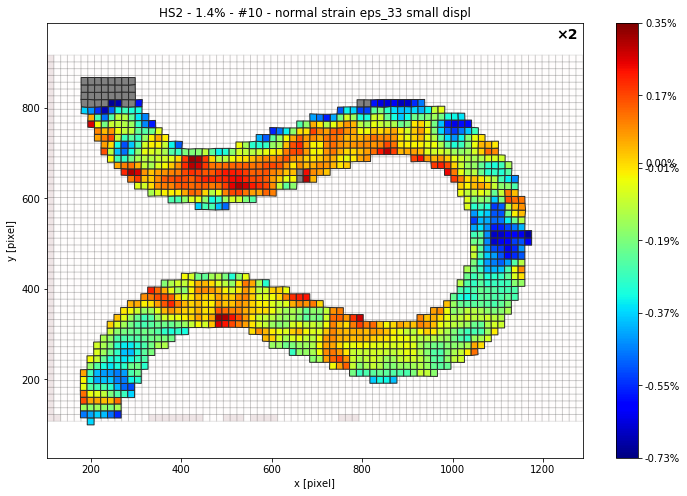

In [75]:
# parameters
field = ['eps_33', 'E_yy', 'E_xx', 'eps_33small'][3]
use_mask = True if 'eps' in field else False
save = False
view_factor = 2

for k in [10]:
#for k in range(len(cube)-1):
    print(f'step {k: 2d}')
    displ_field = displ_to_ref[k]

    u = displ_field[:, 0].reshape(grid[0].shape)
    v = displ_field[:, 1].reshape(grid[0].shape)

    # Smooth, Gaussian moving average :
    sigma = .8
    u = gaussian_filter(u, sigma=sigma, mode='reflect')
    v = gaussian_filter(v, sigma=sigma, mode='reflect')
    
    # Define field shown :
    E = sc.get_LagrangeStrainTensor(*grid, u, v) *100 # percent
    #E = sc.get_InfinitesimalStrainTensor(*grid, u, v) *100  # percent

    if field == 'E_yy':
        field_value = E[:, :, 1, 1]
        #field_name = "Small Def. Strain eps_yy"  #"Lagrange Strain Eyy"
        field_name = "Lagrange Strain E_yy"
    elif field == 'E_xx':
        field_value = E[:, :, 0, 0]
        field_name = "Lagrange Strain E_xx"
    elif field == 'eps_33':
        # Normal strain (the one seen by XRD)
        nu = 0.37
        eps_33 = -nu/(1+nu)*(E[:, :, 0, 0] + E[:, :, 1, 1])
        field_value = eps_33
        field_name = "normal strain eps_33"
    elif field == 'eps_33small':
        E = sc.get_InfinitesimalStrainTensor(*grid, u, v) *100  # percent
        nu = 0.37
        eps_33 = -nu/(1+nu)*(E[:, :, 0, 0] + E[:, :, 1, 1])
        field_value = eps_33
        field_name = "normal strain eps_33 small displ"
        
    print('mean:', np.nanmean(field_value),
          ' median:', np.nanmedian(field_value),
          ' std :', np.nanstd(field_value))

    # Apply mask :
    field_value_masked = np.copy(field_value)
    if use_mask and points_mask is not None:
        field_value_masked[image_mask==False] = np.NaN
    
    # Conditional change of the view factor :
    #d = np.sqrt(u**2 + v**2)
    #if np.nanmax(d) > 50:
    #    view_factor = 1
    #    print("view_factor=", view_factor)
    
    # Graph
    plt.figure(figsize=(12, 8));
    sc.plot_deformed_mesh(grid, displ_field,
                          color_values=field_value_masked,
                          view_factor=view_factor,
                          cmap='jet')#'PiYG')
    plt.title(f'{sample_name} - {stretch_values[k]:.1f}% - #{k:02d} - {field_name}')
    
    # Set color scale
    ref_value = np.nanmedian(field_value)
        
    alpha = 0.03  # def quantile for min-max colors
    half_range = max(+ref_value - np.nanquantile(field_value, alpha),
                     -ref_value + np.nanquantile(field_value, 1 - alpha))
    c_ticks = np.linspace(-half_range + ref_value,
                          +half_range + ref_value, 7)
    # c_ticks = np.sort(np.hstack([c_ticks, [ref_value, ]]))  # add the zero value, not needed if range symmetric
    if np.sign(np.min(c_ticks))*np.sign(np.max(c_ticks)) < 0:
        c_ticks = np.sort(np.hstack([c_ticks, [0, ]]))
    plt.clim([np.min(c_ticks), np.max(c_ticks)])

    cbar = plt.colorbar(ticks=c_ticks);
    cbar.ax.set_yticklabels([f'{u:.2f}%' for u in c_ticks]) ; #
    #cbar.ax.get_yticklabels()[int(np.where(c_ticks == .0)[0])].set_color('red') 
    
    if save:
        output_dir = f'{field_name}_maps' if points_mask is None else f'{field_name}_maps'
        sc.save_fig(f'{field_name}_{k:03d}',
                    sample_name,
                    output_dir, image_ext='png', close=True)

to make a gif

    $ convert -delay 100 -loop 0 *.png myimage.gif

In [67]:
# Save the current state of the notebook with results
notebook_save_path = os.path.join('./output', sample_name, 'post_process.ipynb')
print(notebook_save_path)
%notebook {notebook_save_path}

./output/hpr1/post_process.ipynb


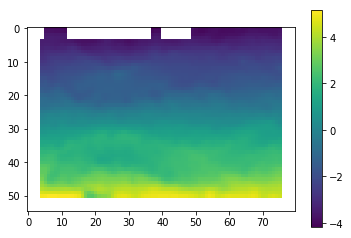

In [76]:
# Graph displacement field
plt.imshow(v); plt.colorbar();

Text(0.5, 1.0, 'profils')

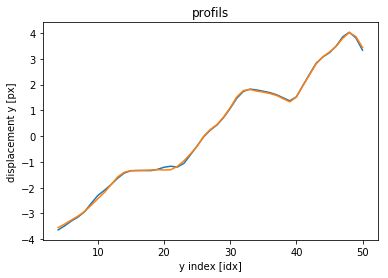

In [82]:
# Profiles
plt.plot(v[:, 21:23]);
plt.ylabel('displacement y [px]');
plt.xlabel('y index [idx]');
plt.title('profils')
#plt.plot(v[:, 20:23]);

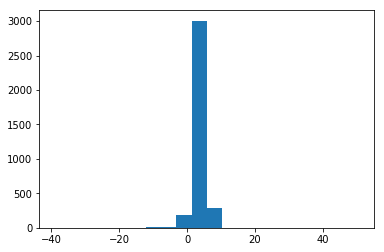

In [112]:
plt.hist(field_value.flatten(), bins=20);